CS4287 Project 1

Name : Szymon Szulc   ID1 : 21323208
Name : Boris Bobylkov ID2 : 21317097

This code executes to the end without error.

Sources:
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://www.tensorflow.org/api_docs/python/tf/keras/Model
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html
https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate


In [36]:
# Importing Libraries 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)


In [37]:
# Load dataset : tf.keras.dataset.mnist
# This data set contains 70,000 28x28 black&white images of digits (0-9)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizing Data : images have pixel values in range [0, 255] - RGB values (Red, Blue, Green colors from range [0, 255].) 
# dynamic range of images 0-255, by /255 we change the range from 0-1. This makes training the model faster.
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Check data type : ensure data is correct format before training.
dataType = x_train.dtype
print(f"Data type: {dataType}")
labelType = y_test.dtype
print(f"Data type: {labelType}")

Data type: float64
Data type: uint8


In [38]:
# This augments the data.

datagen = ImageDataGenerator(
    rotation_range=15,  # rotates the image by 15 degrees.
    width_shift_range=0.1,  # shift image by 0.1
    height_shift_range=0.1,  # shift image by 0.1
    zoom_range=0.1  #zoom into image by rate 0.1
)
# Transforming the data using datagen as a ruleset.
datagen.fit(x_train)

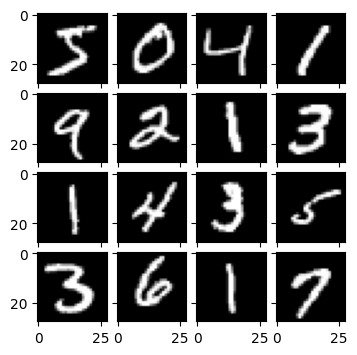

In [39]:
# Data visualization : Display 16 images from training set for visual confirmation of data.
# Imports used in this section: matplotlib.pyplot as plt & mpl_toolkits.axes_grid1 import ImageGrid 
im_list = []  # Empty list to store sample images.
n_samples_to_show = 16  # Number of images to display (4x4 grid)
for i in range(n_samples_to_show):
    im_list.append(x_train[i])  # This appends the first 16 used to visually confirm data.

im_list = [x_train[i] for i in range(n_samples_to_show)]

# Visualization
# Setting up 4x4 grid to visualize images.
fig = plt.figure(figsize=(4, 4))  # setting figure size.

# Ref https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html

grid = ImageGrid(fig, 111,  # similar to subplot(111), used ImageGrid for custom layout.
                 nrows_ncols=(4, 4),  # 4row x 4col grid
                 axes_pad=0.1,  # padding between grid.
                 )

# Display image grid.
for ax, im in zip(grid, im_list):
    # Iterating over the grind returns the Axes.
    ax.imshow(im, 'gray')  #show each image in grayscale
plt.show()  # Show entire grid.


In [40]:
# Model Build
# Building Multi-Layer Perceptron using Keras.
# This model classifies digits (0-9), output = 10 classes.
NUM_CLASSES = 10  # num of classes (0-9)

# Here we define a Sequential model that processes data layer by layer.
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = tf.keras.Sequential([

    # Input Layer : Explicitly define the input shape as (28, 28).
    # Flatten the 28x28 images into 1D vector, as Dense layers expect 1D vector as input.

    tf.keras.Input(shape=(28, 28, 1)),  # Input layer as shape 28x28.
    tf.keras.layers.Flatten(),
    # Creating a flat vector, disregarding locality of features,Representing image as vector.
    tf.keras.layers.Dense(256, activation='relu'),
    # Feeding vector to dense layer, with activation ReLU with 256 neurons.
    tf.keras.layers.Dense(10, activation='softmax'),

    # ReLU: Adds non-linearity by taking the sum of weighted inputs, and adjusts the output. If the sum of weighted input is above 0, it will output itself, if < 0, then it will output 0. This prevents negative inputs from firing negative values. This helps mitigate the vanishing gradient problem - which can cause weighted parameters to update very slowly, or not at all.

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    # Outputs NUM_CLASSES ( number of classes) with sigmoid activation.

    # Sigmoid : squashes output to probability between 0 & 1 for each class. We initially went sigmoid before we found out softmax was better for MNIST dataset.
    # Softmax : Probability distribution over multiple classes : [ 2.0, 1.0, 0.1 ] where [e^2, e^1, e^{0.1}] = [7.39, 2.71, 1.11]. Now we divide by the sum of these, so : 7.39 + 2.71 + 1.11 = 11.21, 
    # [7.39/11.21, 2.71/11.21, 1.11/11.21] = [0.66, 0.24, 0.1], where the first class has 66% probability, next has 24% & last has 10%. The class with the highest probability is chosen (so 66%). The reason why we chose softmax was because sigmoid predicts for each class, while softmax predicts probability over multiple classes, where the sum of these probabilities must = 1.
])

# Compiling model with high-level keras
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
model.compile(optimizer='adam',
              # using adam optimizer - used to adjust learning rate dynamically.

              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

              # Loss : SparseCategoricalCrossentropy is used here as we are dealing with integer labels (0-9)

              # = False, but why? logits are outputs without activation, so we must set as False as we are using sigmoid, which is the activation function. If it was left True, the model would assume that we are not using activation function and try to set the default one on its own.

              # Evaluate model via accuracy

              metrics=['accuracy'])

model_cloned = tf.keras.models.clone_model(model)



# Model training - using data (x_train, y_train) for 10 epochs - 10 iterations.
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# Assigned model.fit() to history variable to plot on graph in next step.
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4670 - loss: 1.6707 - val_accuracy: 0.4952 - val_loss: 1.0475
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5071 - loss: 0.9868 - val_accuracy: 0.5598 - val_loss: 0.8949
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6115 - loss: 0.8186 - val_accuracy: 0.8665 - val_loss: 0.6023
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8707 - loss: 0.5220 - val_accuracy: 0.8786 - val_loss: 0.4210
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8867 - loss: 0.3714 - val_accuracy: 0.8835 - val_loss: 0.3619
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9002 - loss: 0.2978 - val_accuracy: 0.9010 - val_loss: 0.3175
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9530 - loss: 0.2359 - val_accuracy: 0.9666 - val_loss: 0.2131
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9835 - loss: 0.1388 - 

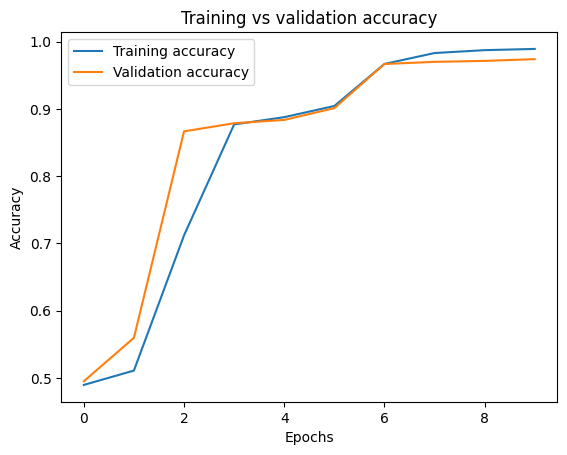

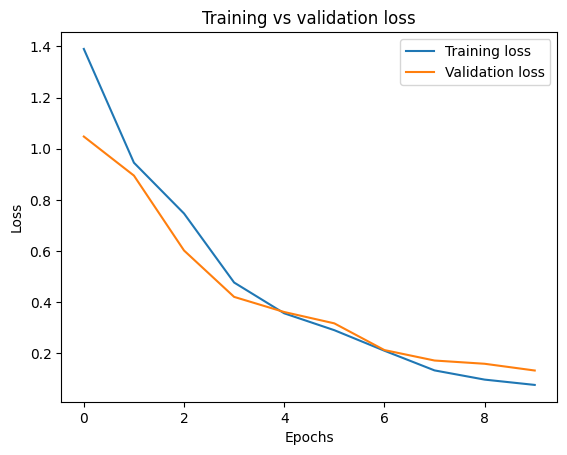

In [41]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs validation loss')
plt.show()

In [42]:
# K-Fold Cross Validation

# Here we are using compile function, same for training the model on whole dataset.
model_cloned.compile(optimizer='adam', 

              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

              metrics=['accuracy'])

# Instead of training dataset a single time, we split the dataset into K number of folds. It used different fold for validation set and K-1 for training set. This ensures that the model is evaluated on every data point as part of validation set. This ensures that we get the most of our dataset by using it for validation and testing.

# Here we create a Kfold object and define number of folds, in our case 5 equal sub-sets.
kf = KFold(n_splits=5)

# kf.split(x_train) : return indices to split the data into train and validation sets of each fold.
for train_index, val_index in kf.split(x_train):
    # contains indices for training set for this fold.
    # contains indices for validation set for this fold.

    # Split data using indices for current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]  # Training and validation inputs
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Training and validation labels

    # Train model for this fold
    # Model is trained on x_train_fold & evaluated on x_val_fold.
    model_cloned.fit(x_train_fold, y_train_fold, epochs=10, verbose=0)

    # Evaluate model on validation set 
    val_loss, val_acc = model_cloned.evaluate(x_val_fold, y_val_fold, verbose=0)

    # Print validation accuracy for current fold.
    print(f"Validation accuracy for this fold : {val_acc * 100:.2f}%")



Validation accuracy for this fold : 96.93%
Validation accuracy for this fold : 98.27%
Validation accuracy for this fold : 99.01%
Validation accuracy for this fold : 99.24%
Validation accuracy for this fold : 99.42%


In [43]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.96      0.96      1010
           4       0.98      0.98      0.98       982
           5       0.96      0.96      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [45]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# Evaluation function calculates loss and accuracy on test data.
eval_loss, eval_acc = model.evaluate(x_test, y_test, verbose=1)
# Print data in % format.
print('Eval accuracy percentage: {:.2f}'.format(eval_acc * 100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9686 - loss: 0.1506
Eval accuracy percentage: 97.38
